# Overview
1. Methylation calling
    - call methylation vectors for all samples
    - call CGmap files and asses methylation individually across the vector
    - call methylation vectors over regions of interest 

## Notebook Setup

In [186]:
# import built-in libraries
import queue
import subprocess


# import third-party libraries
from BSBolt.CallMethylation.CallMethylationVector import CallMethylationVector
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pysam
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

In [2]:
sequencing_directory = ''

In [3]:
sequencing_samples = []

with open(f'{sequencing_directory}samples.txt', 'r') as samples:
    for sample in samples:
        sequencing_samples.append(sample.strip())

In [5]:
alignment_directory = f'{sequencing_directory}alignments/'

## Caclulate Coverage at Every Base

In [195]:
def get_site_coverage(bam_file, contig, min_base_qual):
    alignment_file = pysam.AlignmentFile(bam_file, mode='rb', require_index=True)
    pos_coverage = {}
    for pileup_col in alignment_file.pileup(contig=contig, ignore_overlaps=True, min_base_quality=min_base_qual,
                                            ignore_orphans=False, flag_require=0, flag_filter=1540):
        pos = pileup_col.reference_pos
        coverage = len(pileup_col.get_query_sequences(mark_matches=False, mark_ends=False, add_indels=False))
        pos_coverage[pos] = coverage
    return pos_coverage

In [196]:
all_coverage = {}

for sample in tqdm(sequencing_samples):
    sample_coverage = get_site_coverage(f'{alignment_directory}{sample}.dup.bam', 'nyes', 25)
    all_coverage[sample] = sample_coverage

In [199]:
nyes_annotations =  {'SD': (2107, 2120),
 '3_LTR': (5261, 5775),
 '5_LTR': (1531, 2044),
 'SA': (3056, 3080),
 '1G4_alpha': (3343, 4164),
 '1G4_beta': (4246, 5181),
 'P2A': (4189, 4245),
 'Furin': (4165, 4176),
 'SGSG': (4177, 4188),
 'M13_fwd': (1106, 1123),
 'ColE1_origin': (6308, 6990),
 'LacZ_alpha': (967, 1035),
 'LacO': (5946, 5968),
 'AmpR': (7088, 330),
 'MSCV_Prom_1': (5260, 5641),
 'MSCV_Prom_2': (1529, 1910),
 'Retro_NYESO1_F': (4114, 4134),
 'Retro_NYESO1_R': (4210, 4224),
 '2A_Junction_Probe': (4162, 4183),
 'Primer_Cloning_1': (4024, 4044),
 'Primer_Cloning_2': (4295, 4315)}

In [198]:
coverage_df = pd.DataFrame(all_coverage)

In [201]:
## annotate coverage regions
coverage_annotations = []

for site in coverage_df.index:
    for annotation, span in nyes_annotations.items():
        if span[0] <= site_location <= span[1]:
            site_annotations.append(annotation)
            break
    else:
        coverage_annotations.append('NA') 

In [202]:
coverage_df['annotations'] = coverage_annotations

In [203]:
coverage_df = coverage_df.fillna(0.0)

In [216]:
coverage_df.to_csv('vector_coverage.csv')

In [21]:
sequencing_stages = {}

previous_sample = None
sample_count = 0

for sample in sequencing_samples:
    sample_id = sample.split('_')[0]
    if sample_id != previous_sample:
        sample_count = 0 
        previous_sample = sample_id
    sequencing_stages[sample] = sample_count
    sample_count += 1


In [208]:
coverage_line_plot = []

for sample in list(coverage_df):
    if sample == 'annotations':
        continue
    sample_label = sample.split('_')[0]
    stage = sequencing_stages[sample]
    for site, coverage in zip(coverage_df.index, coverage_df[sample]):
        coverage_line_plot.append(dict(site=site, coverage=coverage, sample=sample_label, stage=stage))

In [209]:
coverage_line_df = pd.DataFrame(coverage_line_plot)

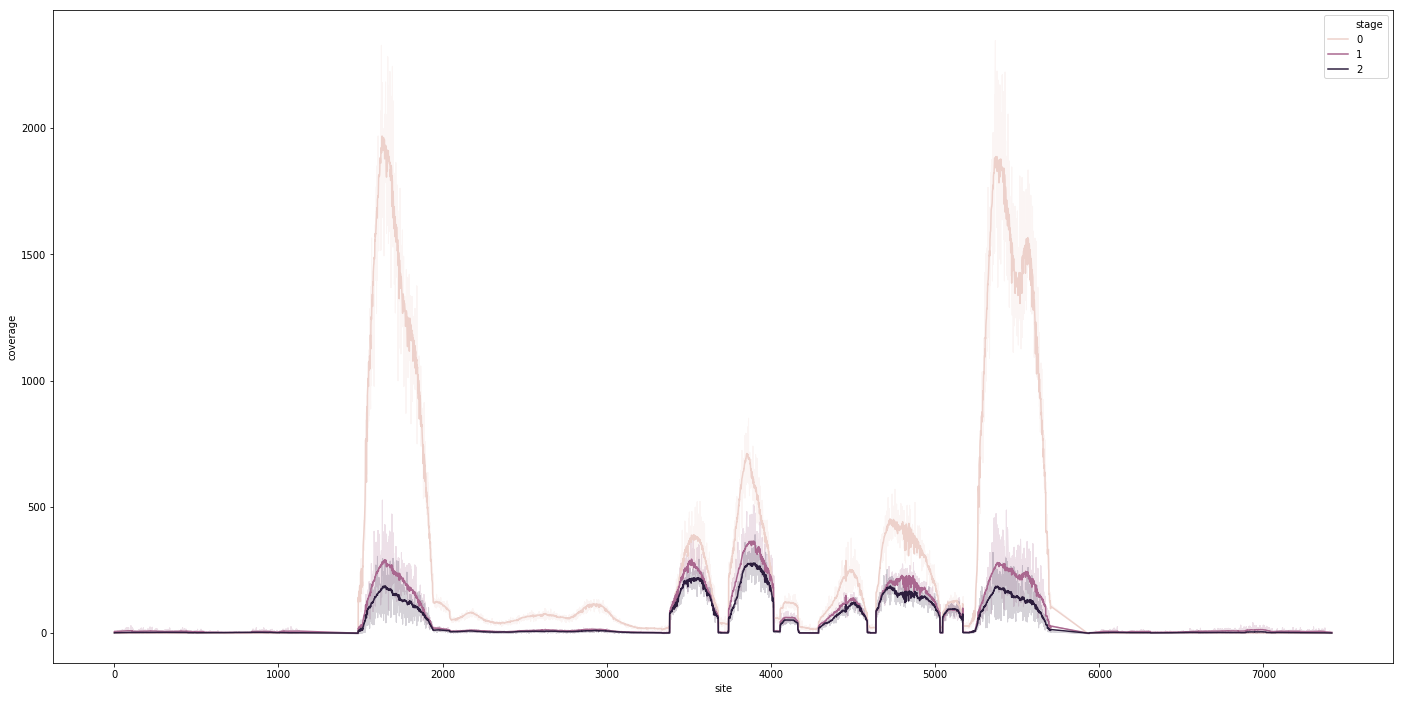

In [224]:
fig, ax = plt.subplots(figsize=(24,12))
sns.lineplot(x='site', y='coverage', hue='stage', data=coverage_line_df, ax=ax, n_boot=1)
plt.show()

## Call Methylation Vectors

In [12]:
nyes = 'nyes'
mart = 'pMSGV1_MART1TCR'

In [13]:
all_vectors = {}


for sample in tqdm(sequencing_samples):
    sample_label = sample.split('_')[0]
    time_frame = int(sample.split('_')[2])
    vector = nyes
    vector_queue = queue.Queue()
    if sample_label[0] == 'F':
        vector = nyes
    vector_caller = CallMethylationVector(input_file=f'{alignment_directory}{sample}.dup.bam',
                                          genome_database='hg38_nyes_db/',
                                          contig=vector, return_queue=vector_queue, min_base_quality=20,
                                          cg_only=True)
    vector_caller.call_methylation()
    sample_vectors = []

    while True:
        values = vector_queue.get()
        sample_vectors.extend(values[1])
        if vector_queue.empty():
            break
    
    all_vectors[sample] = sample_vectors

In [15]:
def get_vector_point_values(vector, chromosome, value_dict):
    for meth_call, pos in zip(vector[3], vector[4]):
        if f'{chromosome}:{pos}' in value_dict:
            if meth_call:
                value_dict[f'{chromosome}:{pos}'][0] += 1
            else:
                value_dict[f'{chromosome}:{pos}'][1] += 1
        else:
            if meth_call:
                value_dict[f'{chromosome}:{pos}'] = [1, 0]
            else:
                value_dict[f'{chromosome}:{pos}'] = [0, 1]

In [17]:
all_values = {}
all_observed_cpg_sites = {nyes:set(), mart:set()}

for sample, called_vectors in all_vectors.items():
    vector = nyes
    if sample[0] == 'F':
        vector = nyes
    vector_values = {}
    for meth_vector in called_vectors:
        get_vector_point_values(meth_vector, vector, vector_values)
        for site in meth_vector[4]:
            all_observed_cpg_sites[vector].add(site)
    all_values[sample] = vector_values

In [19]:
mart_observed_sites = sorted(list(all_observed_cpg_sites[mart]))
nyes_observed_sites = sorted(list(all_observed_cpg_sites[nyes]))

In [20]:
mart_count = {site:count for count, site in enumerate(mart_observed_sites)}
nyes_count = {site:count for count, site in enumerate(nyes_observed_sites)}

vector_counts = {nyes:nyes_count, mart:mart_count}

In [179]:
def get_methylation_values(methylation_counts):
    sample_values = {}
    for sample, calls in methylation_counts.items():
        proportions= {}
        for label, call in calls.items():
            total = call[0] + call[1]
            pos = int(label.split(':')[1])
            if total >= 10:
                proportions[pos] = call[0] / total
            else:
                proportions[pos] = np.nan
        sample_values[sample] = proportions
    return sample_values

In [180]:
values = get_methylation_values(all_values)

In [182]:
value_df = pd.DataFrame(values)

In [222]:
value_df.to_csv('vector_methylation_values.csv', na_rep='n/a')

In [183]:
all_beta_values = []

for key, calls in all_values.items():
    for site, call in calls.items():
        total_cytosines = call[1] + call[0]
        if total_cytosines >= 10:
            vector, pos = site.split(':')
            methylation_value = call[0] / total_cytosines
            sample = key.split('_')[0]
            day = int(key.split('_')[-2])
            stage = sequencing_stages[key]
            all_beta_values.append(dict(vector=vector, pos=int(pos), pos_count=vector_counts[vector][int(pos)],
                                  methylation_value=methylation_value, day=day, stage=stage, sample=sample, coverage=total_cytosines))

In [184]:
beta_df = pd.DataFrame(all_beta_values)
nyes_df = beta_df.loc[beta_df['vector'] == nyes]
mart_df = beta_df.loc[beta_df['vector'] == mart]

In [218]:
site_annotations = []

for site_location in value_df.index:
    for annotation, span in nyes_annotations.items():
        if span[0] <= site_location <= span[1]:
            site_annotations.append(annotation)
            break
    else:
        site_annotations.append('NA')

In [219]:
print(len(site_annotations))

615


In [220]:
value_df['annotations'] = site_annotations

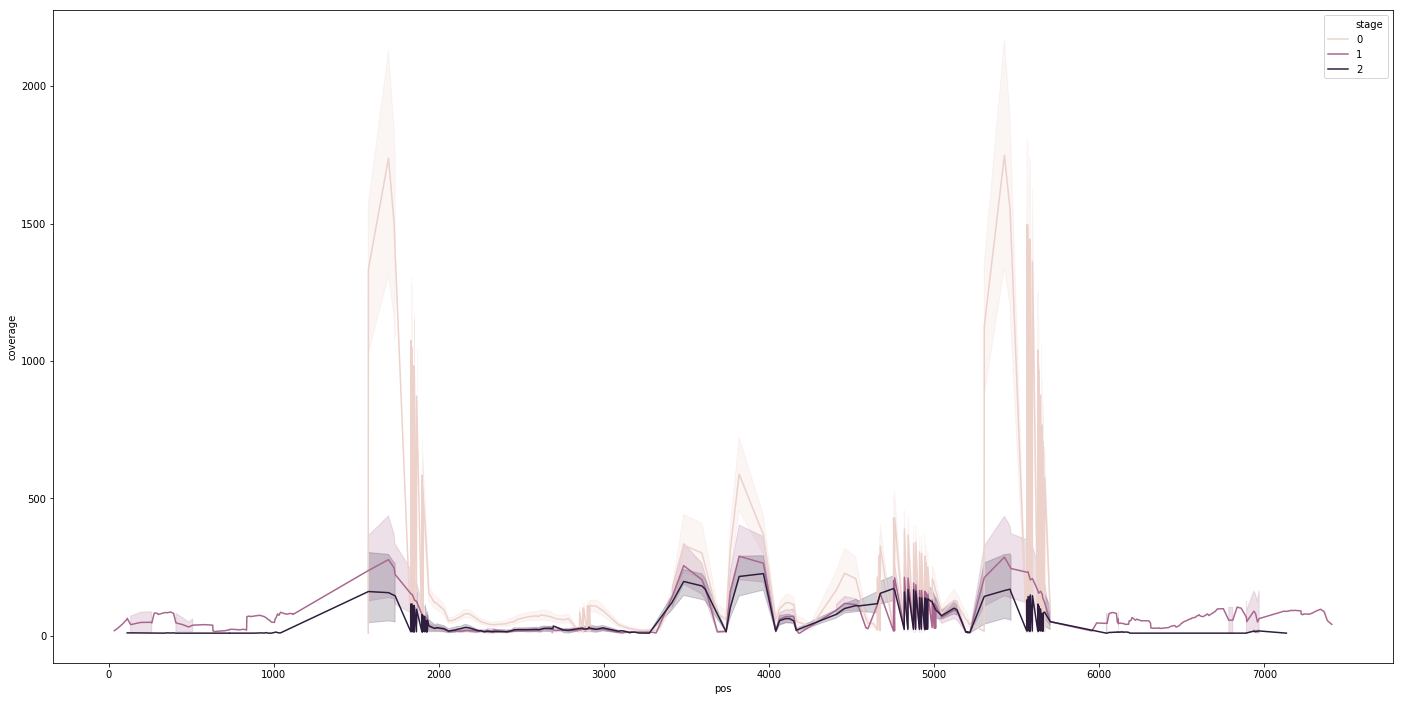

In [167]:
fig, ax = plt.subplots(figsize=(24,12))
sns.lineplot(x='pos', y='coverage', hue='stage', data=beta_df, ax=ax, markers=True)
plt.show()

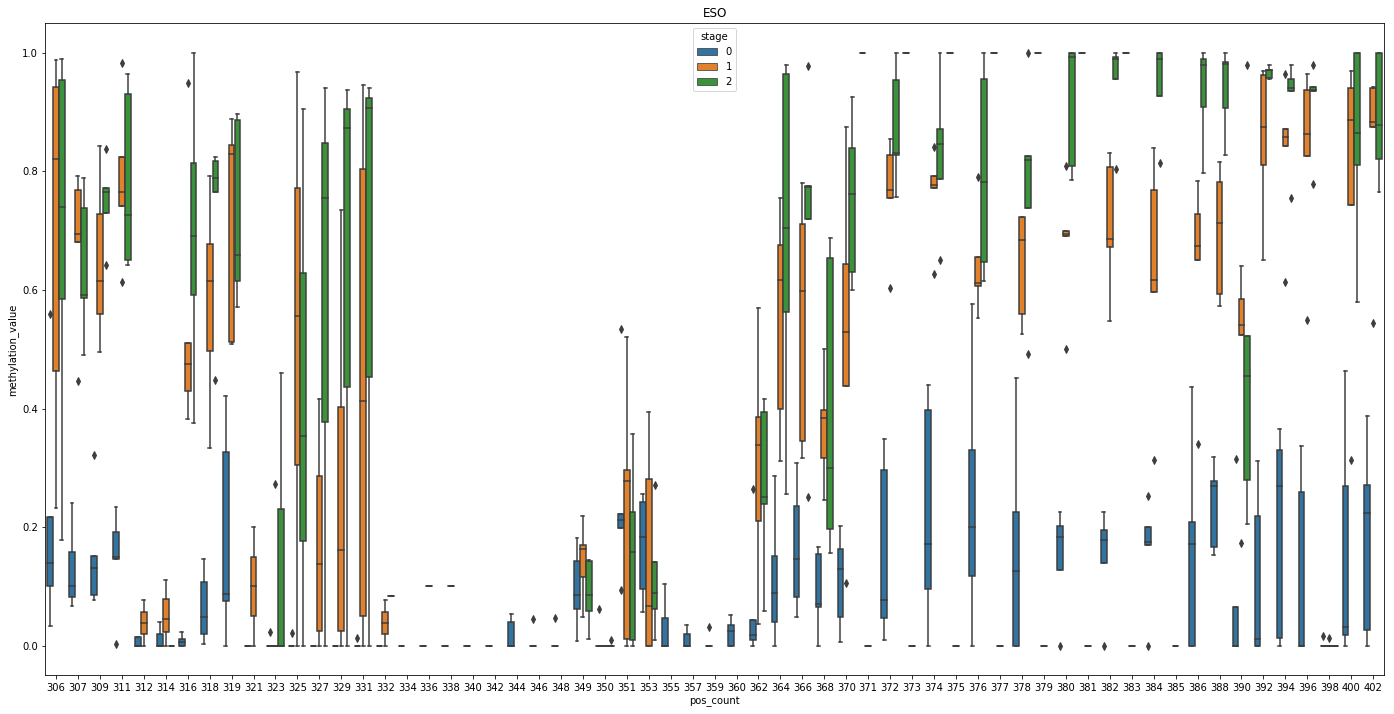

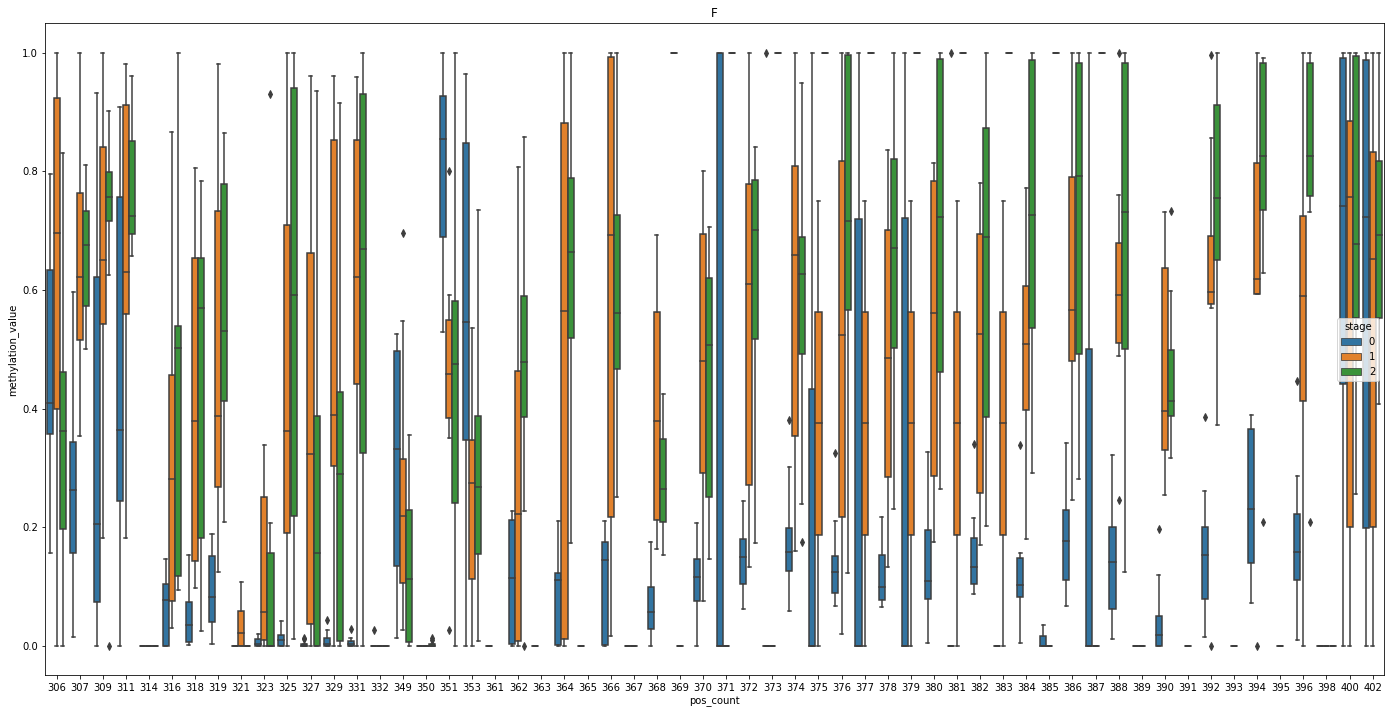

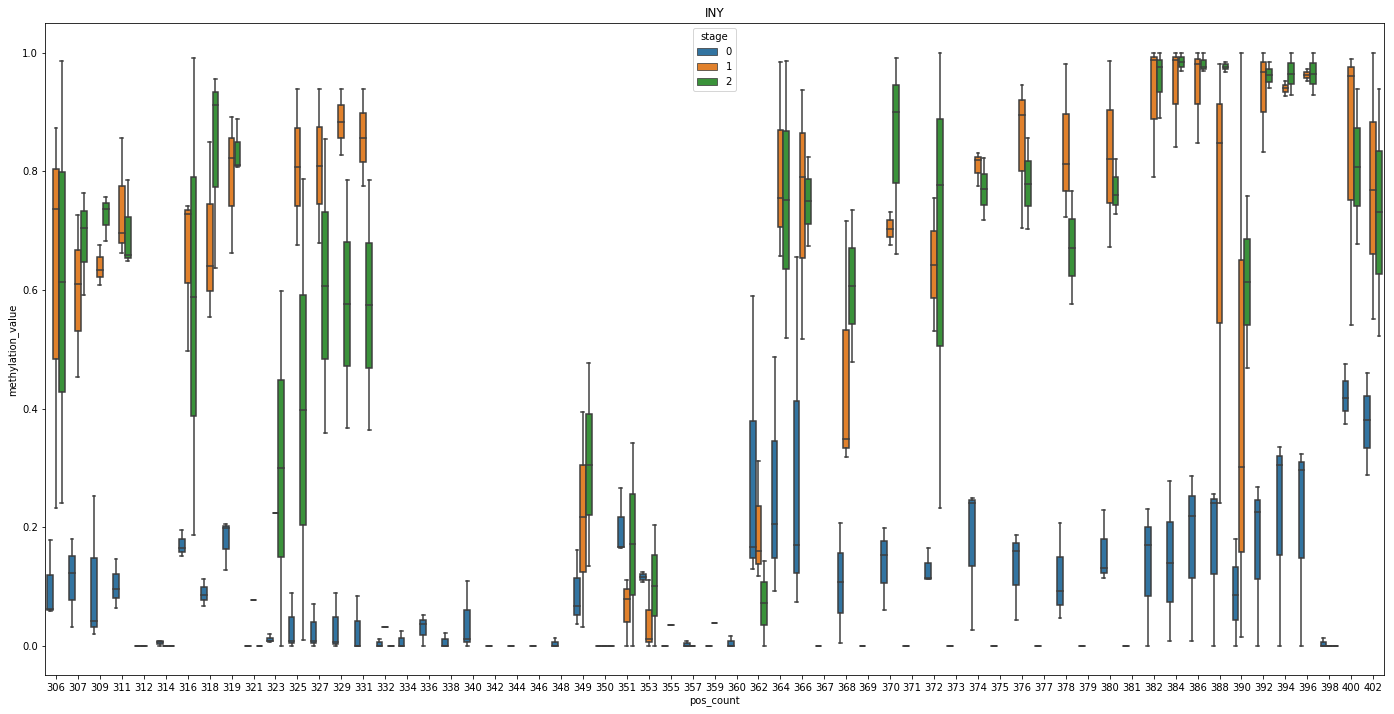

In [39]:
for group in ['ESO', 'F', 'INY']:
    samples = list(set([sample for sample in nyes_df['sample'] if sample[0] == group[0]]))
    fig, ax = plt.subplots(figsize=(24,12))
    plot_df = nyes_df.loc[(nyes_df['pos'] >= 3343) & (nyes_df['pos'] <= 5181)]
    sns.boxplot(x='pos_count', y='methylation_value', hue='stage', data=plot_df.loc[nyes_df['sample'].isin(samples)], ax=ax)
    ax.set_title(group)
    plt.show()

In [ ]:
for annotation, span in nyes_annotations.items():
    plot_df = nyes_df.loc[(nyes_df['pos'] >= span[0]) & (nyes_df['pos'] <= span[1])]
    if plot_df.shape[0] > 20:
        fig, ax = plt.subplots(figsize=(24,12))

        sns.boxplot(x='pos', y='methylation_value', hue='stage', data=plot_df, ax=ax)
        #sns.swarmplot(x='pos', y='methylation_value', hue='stage', data=plot_df, ax=ax)
        ax.set_title(annotation, fontsize=16)
        ax.set_ylim(0.0, 1.1)
        plt.show() 

In [18]:
mart_annotations = {'5_LTR': (382, 515),
                    'MSCV_promoter_1': (1, 381),
                    'SD': (578, 591),
                    'SA': (1527, 1551),
                    'Furin': (2641, 2652),
                    'P2A': (2704, 2760),
                    'Mart1_TCR_alpha': (1822, 2703),
                    'MART1_TCR_b_chain': (2761, 3747), 
                    '3_LTR': (4207, 4340),
                    'MSCV_promoter_2': (3826, 4206),
                    'LacZ_alpha': (6949, 7017),
                    'LacO': (4511, 4533),
                    'AmpR': (5653, 6312)}  

In [19]:
for annotation, span in mart_annotations.items():
    plot_df = mart_df.loc[(mart_df['pos'] >= span[0]) & (mart_df['pos'] <= span[1])]
    if plot_df.shape[0] > 10:
        fig, ax = plt.subplots(figsize=(24,12))

        sns.boxplot(x='pos', y='methylation_value', hue='stage', data=plot_df, ax=ax)
        #sns.swarmplot(x='pos', y='methylation_value', hue='stage', data=plot_df, ax=ax)
        ax.set_title(annotation, fontsize=16)
        ax.set_ylim(0.0, 1.1)
        plt.show() 

### Get number of reads that map to vector and genome

In [19]:
def get_index_stats(sequencing_file):
    index_stats = {}
    index = subprocess.Popen(['samtools', 'idxstats', sequencing_file], stdout=subprocess.PIPE, universal_newlines=True)
    total_bases = 0
    total_reads = 0
    for line in iter(index.stdout.readline, ''):
        line_split = line.strip().split('\t')
        bases, reads = int(line_split[1]), int(line_split[2])
        index_stats[line_split[0]] = (bases, reads)
        total_bases += bases
        total_reads += reads
    index_stats['total'] = (total_bases, total_reads)
    return index_stats

In [20]:
sample_counts = {}


for sample in sequencing_samples:
    stats = get_index_stats(f'{alignment_directory}{sample}.dup.bam')
    sample_counts[sample] = stats

In [21]:
# f to mart1

sample_read_counts = {}

for sample, counts in sample_counts.items():
    sample_label = sample.split('_')[0]
    time_frame = int(sample.split('_')[2])
    vector = nyes
    if sample_label[0] == 'F':
        vector = mart
    vector_counts = counts[vector][1]
    if sample_label not in sample_read_counts:
        sample_read_counts[sample_label] = [counts['total'][1], counts[vector][1], time_frame]
    else:
        sample_read_counts[sample_label].append(counts[vector][1])
        sample_read_counts[sample_label].append(time_frame)   

In [22]:
count_df = pd.DataFrame(sample_read_counts).T

In [23]:
count_df.columns = ['TotalReads', 'Time1Reads', 'Time1Day', 'Time2Reads', 'Time2Day', 'Time3Reads', 'Time3Day']

In [24]:
count_df['Time1Prop'] = count_df['Time1Reads'] / count_df['TotalReads']
count_df['Time2Prop'] = count_df['Time2Reads'] / count_df['TotalReads']
count_df['Time3Prop'] = count_df['Time3Reads'] / count_df['TotalReads']

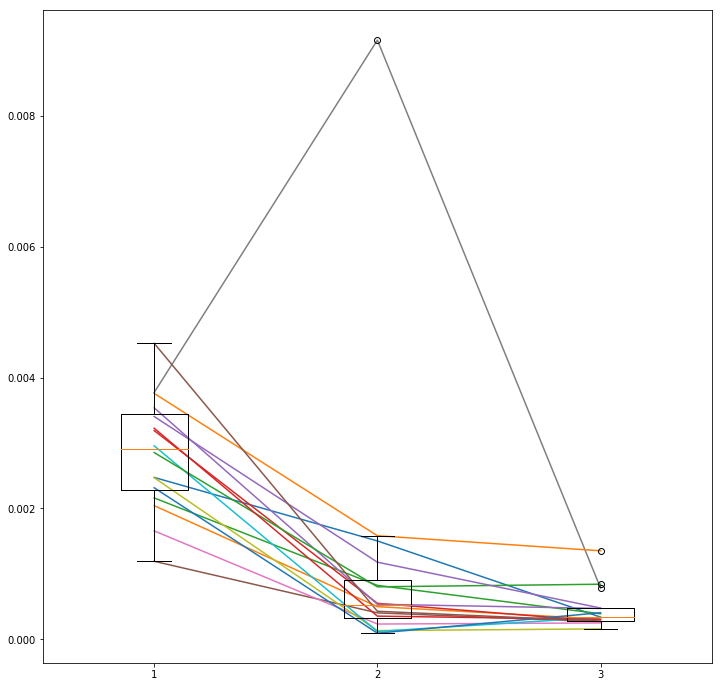

In [25]:
fig, ax = plt.subplots(figsize=(12,12))

for sample in count_df[['Time1Prop', 'Time2Prop', 'Time3Prop']].values:    
    ax.plot([1,2,3], sample)
ax.boxplot(count_df[['Time1Prop', 'Time2Prop', 'Time3Prop']].values)



plt.show()

In [26]:
count_df[['Time1Prop', 'Time2Prop', 'Time3Prop']]

,Time1Prop,Time2Prop,Time3Prop
ESO1,0.002474,0.001504,0.000340
ESO3,0.002043,0.000499,0.000310
ESO4,0.002160,0.000824,0.000390
ESO5,0.003190,0.000550,0.000276
ESO6,0.003537,0.000536,0.000472
F12,0.001192,0.000405,0.000267
F13,0.001657,0.000234,0.000251
F1,0.003772,0.009156,0.000783
F3,0.002470,0.000133,0.000160
F6,0.002957,0.000121,0.000337
